## Introduction

TEAMMATES: Akshat and Annie

The overall goal is to predict whether a payment by a company to a medical doctor or facility
was made as part of a research project or not.

### Imports

In [189]:
# data loading and manipulation
import pandas as pd
import numpy as np
import random
from dirty_cat import TargetEncoder

# scikit learn
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, confusion_matrix, roc_auc_score, auc, average_precision_score

# unbalanced sets
from imblearn.under_sampling import RandomUnderSampler

# plotting
import matplotlib.pyplot as plt

%matplotlib inline

### Load data

The positive class corresponds to the payments that were made by a company to a doctor or facility that is part of the **research project**. The negative class on the other hand are the **general payments**. 

In the original data sets, the ratio of the positive class to the negative class is 1/20, making the positive class the minority class. 

Because the data sets are so large, we will subsample from the classes in order to maintain the same ratio. Thus we take 120K data points from Class 0, and 20K data points from Class 1. 

120K from the positive class turns out to be ~20% of the data, and 2M from the negative class is ~20% from the negative class. 

In [7]:
# Import 20% data randomly
p = 0.2
df0 = pd.read_csv('../payments2017/d0.csv', skiprows=lambda i: i>0 and random.random() > p)
df1 = pd.read_csv('../payments2017/d1.csv', skiprows=lambda i: i>0 and random.random() > p)

/Users/antonialovjer/anaconda3/envs/aml/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (4,7,9,11,14,16,17,21,22,23,24,35,36,37,40,41,42,43,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/antonialovjer/anaconda3/envs/aml/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (2,5,7,8,9,10,15,17,18,19,20,21,22,23,24,30,37,38,42,43,44,45,47,48,49,50,51,52,53,54,55,56,59,60,61,62,67,68,69,70,71,72,73,74,75,76,79,80,81,87,88,89,90,91,92,93,94,95,96,99,100,101,107,108,109,111,112,113,114,115,116,119,120,121,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,160,161,162,173,174,175) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
df0.shape

(2131477, 75)

In [9]:
df1.shape

(119997, 176)

## Feature Intersection

What features should be excluded because they leak the target information?

There are 75 features present in the negative class, and 176 in the positive class. Our approach to combining the data sets for both the positive and the negative classs it to take an intersection of the features. 

In [10]:
notPrs = list(set(list(df1.columns)).difference(list(df0.columns)))
featureIntersection = list(set(list(df1.columns)).difference(notPrs))
print("There are {} features present in the intersection of the two dataframes.".format(len(featureIntersection)))

df1 = df1[featureIntersection]
df0 = df0[featureIntersection]

There are 64 features present in the intersection of the two dataframes.


Before we concatenate the two data sets, we add an indicator variable to each one specifying which class the data belongs to. We call this feature **target**, which is equal to 1 for the positive class and 0 for the negative class.

In [11]:
df1['Target'] = 1
df0['Target'] = 0

df = pd.concat([df1, df0], axis=0)
df.shape

(2251474, 65)

In [12]:
NAs = df.isna().mean().sort_values(ascending=False)

In [13]:
NAs

Recipient_Province                                                  0.999934
Recipient_Postal_Code                                               0.999918
Physician_License_State_code5                                       0.999846
Physician_License_State_code4                                       0.999205
Associated_Drug_or_Biological_NDC_5                                 0.997626
Physician_License_State_code3                                       0.995423
Product_Category_or_Therapeutic_Area_5                              0.993545
Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_5           0.993408
Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_5            0.993339
Covered_or_Noncovered_Indicator_5                                   0.993225
Teaching_Hospital_CCN                                               0.987683
Teaching_Hospital_ID                                                0.987683
Teaching_Hospital_Name                                              0.987683

In [58]:
columns_to_drop = ['Recipient_Province', 
'Recipient_Postal_Code', 
'Recipient_Primary_Business_Street_Address_Line2',
'Teaching_Hospital_Name', 
'Teaching_Hospital_CCN',
'Teaching_Hospital_ID',
'Physician_Name_Suffix',       
'Program_Year', 
'Physician_Profile_ID', 
'Physician_Last_Name', 
'Physician_First_Name',
'Record_ID',
'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID',
'Physician_Profile_ID',
'Recipient_Zip_Code',
'Date_of_Payment',
'Physician_Middle_Name'   
]

**Baseline**

In [59]:
nan_columns = NAs[NAs > 0] 
nan_columns = np.array(nan_columns.index)
to_drop_baseline = list(set(nan_columns) | set(columns_to_drop))

In [63]:
dfBaseline = df.drop(columns=to_drop_baseline, axis ='columns')

In [64]:
dfBaseline.shape

(2251474, 12)

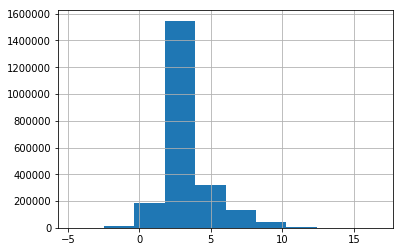

In [17]:
np.log(dfTest['Total_Amount_of_Payment_USDollars']).hist()


In [65]:
dfBaseline.columns

Index(['Related_Product_Indicator',
       'Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name',
       'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name',
       'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country',
       'Dispute_Status_for_Publication', 'Delay_in_Publication_Indicator',
       'Change_Type', 'Covered_Recipient_Type',
       'Form_of_Payment_or_Transfer_of_Value', 'Payment_Publication_Date',
       'Total_Amount_of_Payment_USDollars', 'Target'],
      dtype='object')

In [66]:
dfBaseline.head()

,Related_Product_Indicator,Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name,Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name,Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country,Dispute_Status_for_Publication,Delay_in_Publication_Indicator,Change_Type,Covered_Recipient_Type,Form_of_Payment_or_Transfer_of_Value,Payment_Publication_Date,Total_Amount_of_Payment_USDollars,Target
0,Yes,"Nielsen BioSciences, Inc.","Nielsen BioSciences, Inc.",United States,No,No,UNCHANGED,Covered Recipient Physician,Cash or cash equivalent,01/18/2019,8531.00,1
1,Yes,"Nielsen BioSciences, Inc.","Nielsen BioSciences, Inc.",United States,No,No,UNCHANGED,Covered Recipient Physician,Cash or cash equivalent,01/18/2019,49312.50,1
2,No,Mission Pharmacal Company,Mission Pharmacal Company,United States,No,No,UNCHANGED,Covered Recipient Physician,Cash or cash equivalent,01/18/2019,625.00,1
3,Yes,Mission Pharmacal Company,Mission Pharmacal Company,United States,No,No,UNCHANGED,Covered Recipient Physician,Cash or cash equivalent,01/18/2019,216.00,1
4,No,Mission Pharmacal Company,Mission Pharmacal Company,United States,No,No,UNCHANGED,Covered Recipient Physician,Cash or cash equivalent,01/18/2019,1584.53,1


In [97]:
x = dfBaseline['Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name'].unique()
len(x)

1235

In [151]:
X_train.columns

(1688605, 11)

In [153]:
pd.DataFrame(X_train_rus)

,0,1,2,3,4,5,6,7,8,9,10
0,Yes,Concordia Pharmaceuticals Inc.,Concordia Pharmaceuticals Inc.,Barbados,No,No,UNCHANGED,Covered Recipient Physician,Cash or cash equivalent,01/18/2019,15.07
1,Yes,AstraZeneca Pharmaceuticals LP,AstraZeneca Pharmaceuticals LP,United States,No,No,UNCHANGED,Covered Recipient Physician,In-kind items and services,01/18/2019,16.48
2,Yes,Allergan Inc.,Allergan Inc.,United States,No,No,UNCHANGED,Covered Recipient Physician,In-kind items and services,01/18/2019,7.74
3,Yes,Sanofi and Genzyme US Companies,SANOFI-AVENTIS U.S. LLC,United States,No,No,UNCHANGED,Covered Recipient Physician,In-kind items and services,01/18/2019,12.43
4,Yes,"Smith & Nephew, Inc.","Smith & Nephew, Inc.",United States,No,No,UNCHANGED,Covered Recipient Physician,In-kind items and services,01/18/2019,10.32
5,Yes,Pfizer Inc.,PFIZER INC.,United States,No,No,UNCHANGED,Covered Recipient Physician,In-kind items and services,01/18/2019,12.22
6,Yes,Celgene Corporation,Celgene Corporation,United States,No,No,UNCHANGED,Covered Recipient Physician,Cash or cash equivalent,01/18/2019,3410
7,Yes,Astellas Pharma US Inc,Astellas Pharma US Inc,United States,No,No,UNCHANGED,Covered Recipient Physician,In-kind items and services,01/18/2019,17.25
8,Yes,Novo Nordisk Inc,Novo Nordisk Inc,United States,No,No,UNCHANGED,Covered Recipient Physician,In-kind items and services,01/18/2019,17.61
9,Yes,Sanofi and Genzyme US Companies,SANOFI-AVENTIS U.S. LLC,United States,No,No,UNCHANGED,Covered Recipient Physician,In-kind items and services,01/18/2019,15.46


In [154]:
objVars = ['Related_Product_Indicator',
           'Dispute_Status_for_Publication', 'Delay_in_Publication_Indicator',
           'Change_Type', 'Covered_Recipient_Type',
           'Form_of_Payment_or_Transfer_of_Value', 'Payment_Publication_Date',
           'Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name',
           'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name',
           'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country']

contVars = ['Total_Amount_of_Payment_USDollars']

target = dfBaseline['Target']
features = dfBaseline.drop(columns='Target')

X_train, X_test, y_train, y_test = train_test_split(features, target)

rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

contVars_ct = ColumnTransformer([
    ("scalar", StandardScaler(), 'Total_Amount_of_Payment_USDollars')])

catVars_ct = ColumnTransformer([
    ("dummies", OneHotEncoder(handle_unknown='ignore'), objVars)])

# ("target_encoder", TargetEncoder(clf_type="binary_clf"), target_based_encoding)

baseline_pipe = Pipeline([
                        ("catvars", catVars_ct),
                        ("logreg", LogisticRegression())])
    
logreg = baseline_pipe.fit(pd.DataFrame(X_train_rus, columns = X_train.columns), pd.DataFrame(y_train_rus))
baseline_score = logreg.score(X_test, y_test)
baseline_score

/Users/antonialovjer/anaconda3/envs/aml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/antonialovjer/anaconda3/envs/aml/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9902606112612349

In [162]:
y_score = logreg.fit(pd.DataFrame(X_train_rus, columns = X_train.columns), pd.DataFrame(y_train_rus)).decision_function(X_test)

/Users/antonialovjer/anaconda3/envs/aml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/antonialovjer/anaconda3/envs/aml/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [185]:
preds = logreg.predict(X_test)
tn, fp, fn, tp  = confusion_matrix(y_test, preds).ravel()
print([tn, fp])
print([fn, tp])

[527764, 5018]
[464, 29623]


In [157]:
roc_auc_score(y_test, preds)

0.9875797853039253

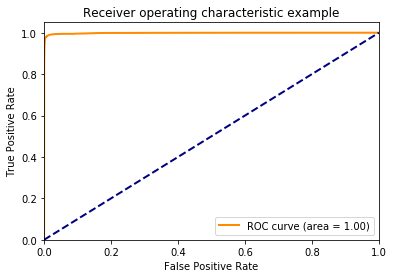

In [175]:
plot_roc(y_test, y_score)

In [186]:
def plot_roc(y_test, y_score):
    
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    roc_auc = auc(fpr, tpr)
    
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [191]:
average_precision_score(y_test, y_score)

0.9896610262503588

In [180]:
y_prob = logreg.predict_proba(X_test)

In [184]:
pd.DataFrame(y_prob, y_test)

,0,1
Target,,
0,0.999761,0.000239
0,0.999808,0.000192
1,0.000071,0.999929
0,0.914557,0.085443
0,0.999859,0.000141
0,0.997541,0.002459
0,0.999573,0.000427
0,0.988084,0.011916
0,0.404898,0.595102
